<a href="https://colab.research.google.com/github/ldselvera/huggingface/blob/main/04-Audio-Models/Audio_Transcription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# must request access to https://huggingface.co/pyannote/speaker-diarization-3.1
# must request access to https://huggingface.co/pyannote/segmentation-3.0
# !pip install pyannote.audio

In [3]:
from pyannote.audio import Pipeline

In [7]:
diarization_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization-3.1", use_auth_token=True)

config.yaml:   0%|          | 0.00/469 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.91M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/399 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/26.6M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/221 [00:00<?, ?B/s]

In [8]:
from pyannote.audio.pipelines.utils.hook import ProgressHook

In [9]:
with ProgressHook() as hook:
    diarization = diarization_pipeline("interview.mp3", hook=hook)

Output()

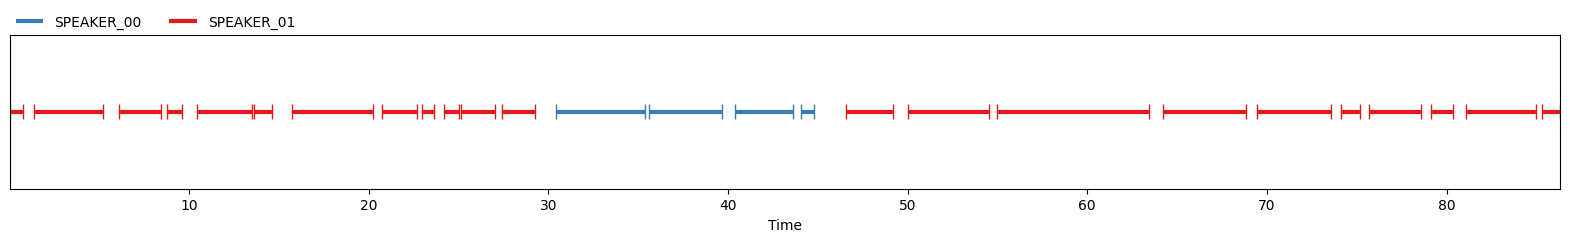

In [11]:
diarization

In [10]:
for turn, _, speaker in diarization.itertracks(yield_label=True):
    print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")

start=0.0s stop=0.8s speaker_SPEAKER_01
start=1.4s stop=5.2s speaker_SPEAKER_01
start=6.1s stop=8.4s speaker_SPEAKER_01
start=8.8s stop=9.6s speaker_SPEAKER_01
start=10.5s stop=13.5s speaker_SPEAKER_01
start=13.6s stop=14.6s speaker_SPEAKER_01
start=15.7s stop=20.2s speaker_SPEAKER_01
start=20.8s stop=22.7s speaker_SPEAKER_01
start=23.0s stop=23.6s speaker_SPEAKER_01
start=24.2s stop=25.0s speaker_SPEAKER_01
start=25.1s stop=27.0s speaker_SPEAKER_01
start=27.4s stop=29.2s speaker_SPEAKER_01
start=30.4s stop=35.4s speaker_SPEAKER_00
start=35.6s stop=39.7s speaker_SPEAKER_00
start=40.4s stop=43.6s speaker_SPEAKER_00
start=44.0s stop=44.8s speaker_SPEAKER_00
start=46.6s stop=49.2s speaker_SPEAKER_01
start=50.0s stop=54.5s speaker_SPEAKER_01
start=55.0s stop=63.4s speaker_SPEAKER_01
start=64.2s stop=68.8s speaker_SPEAKER_01
start=69.5s stop=73.5s speaker_SPEAKER_01
start=74.1s stop=75.2s speaker_SPEAKER_01
start=75.7s stop=78.6s speaker_SPEAKER_01
start=79.1s stop=80.4s speaker_SPEAKER_01


In [12]:
def consolidate_speaker_segments(diarization):
    consolidated_segments = []
    current_speaker = None
    segment_start = None

    for turn, _, speaker in diarization.itertracks(yield_label=True):
        if speaker != current_speaker:
            if current_speaker is not None:
                consolidated_segments.append((current_speaker, segment_start, turn.start))
            current_speaker = speaker
            segment_start = turn.start
        segment_end = turn.end

    if current_speaker is not None:
        consolidated_segments.append((current_speaker, segment_start, segment_end))

    return consolidated_segments

In [13]:
segments = consolidate_speaker_segments(diarization)
segments

[('SPEAKER_01', 0.03096875, 30.43971875),
 ('SPEAKER_00', 30.43971875, 46.555343750000006),
 ('SPEAKER_01', 46.555343750000006, 86.31284375)]

In [15]:
# ! pip install pydub

In [16]:
from pydub import AudioSegment
import os

def split_audio_segments(audio_file, segments, output_dir='segmented_audio'):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Load the audio file
    audio = AudioSegment.from_file(audio_file)

    # Iterate over the segments and export each one
    for idx, (speaker, start, end) in enumerate(segments):
        # Calculate start and end in milliseconds
        start_ms = start * 1000
        end_ms = end * 1000

        # Extract the segment
        segment = audio[start_ms:end_ms]

        # Create the output file name
        speaker_label = speaker.split('_')[-1]  # Get speaker identifier
        output_file = os.path.join(output_dir, f"{idx:02d}_SPEAKER{speaker_label}_START{start:.0f}_STOP{end:.0f}.mp3")

        # Export the segment
        segment.export(output_file, format="mp3")
        print(f"Exported {output_file}")

In [17]:
split_audio_segments('interview.mp3', segments)

Exported segmented_audio/00_SPEAKER01_START0_STOP30.mp3
Exported segmented_audio/01_SPEAKER00_START30_STOP47.mp3
Exported segmented_audio/02_SPEAKER01_START47_STOP86.mp3


In [18]:
from transformers import pipeline

In [19]:
pipe = pipeline("automatic-speech-recognition", model="facebook/wav2vec2-base-960h")

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

In [20]:
pipe('interview.mp3')

{'text': "MOST OF US WOULD BE SURPRISED TO HEAR THAT THE UNIVERSE IS GOING TO END ONE DAY WE EXPECT THE UNIVERSE TO GO ON FOREVER INTO THE FUTURE WHY DO WE HAVE THE IDEA THAT IT DOESN'T GO ON FOREVER INTO THE PAST I NOT SAYING I KNOW THE ANSWER TO THIS THIS IS ONE OF THE DEEPEST QUESTIONS WE DO NOT KNOW THE ANSWER WE SIMPLY HAVE TO KEEP AN OPEN MIND ALL OF US PHILOSOPHERS SCIENCES RELIGIOUS PEOPLE NO ONE IN FACT KNOWS YOU MAKE THE ARGUMENT IN PALE BLUE DOT THAT IT'S TIME TO HIT THE ROAD AGAIN SKYWARD AS IN SPACE TRAVEL EXPLORATION PERHAPS COLONIES FOR THE VERY SALVATION OF THE SPECIES HOW IS THAT WELL FIRST OFFI AS YOU SUGGEST WE WE ARE A WANDERING SPECIES WE COME FROM HUNTER GATHERERS WE ORE NOMADS AND FOR THE MILLION YEARS THAT THE HUMAN FAMILY HAS BEEN AROUND THAT WAS OUR LIFE STYLE THAT MUST BE BUILT INTO US DEEPLY IT'S ONLY THE LAST TEN THOUSAND YEARS THAT WE'VE HAD A SETTLED AND SEDENTARY EXISTENCE AND NOW THE EARTH IS ALL EXPLORED OUR EXPLORATORY INSTINCTS SIR UNFULFILLED AND I 

In [21]:
import os
import re

def process_segmented_files(directory='segmented_audio'):
    # Ensure the directory exists
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory '{directory}' does not exist.")

    # List all files in the directory
    files = os.listdir(directory)


    # Process each file
    for file in files:
        file_path = os.path.join(directory, file)
        if os.path.isfile(file_path):
            text = pipe(file_path)['text']
            num,speaker,time_start,time_stop = file.split('_')
            time_stop = time_stop.replace(".mp3",'')
            print(f"{speaker}-- {time_start}sec {time_stop}sec:\n{text}")
            print('\n\n')

In [22]:
process_segmented_files()

SPEAKER01-- START0sec STOP30sec:
MOST OF US WOULD BE SURPRISED TO HEAR THAT THE UNIVERSE IS GOING TO END ONE DAY WE EXPECT THE UNIVERSE TO GO ON FOREVER INTO THE FUTURE WHY DO WE HAVE THE IDEA THAT IT DOESN'T GO ON FOREVER INTO THE PAST I'M NOT SAYING I KNOW THE ANSWER TO THIS THIS IS ONE OF THE DEEPEST QUESTIONS AND WE DO NOT KNOW THE ANSWER WE SIMPLY HAVE TO KEEP AN OPEN MIND ALL OF US PHILOSOPHERS SCIENCES RELIGIOUS PEOPLE NO ONE IN FACT KNOWS



SPEAKER01-- START47sec STOP86sec:
WELL FIRST OFF AS YOU SUGGEST WE A WE ARE A WANDERING SPECIES WE COME FROM HUNTER GATHERERS WE ORE GNOMADS AND FOR THE MILLION YEARS THAT THE HUMAN FAMILY HAS BEEN AROUND THAT WAS OUR LIFE STYLE THAT MUST BE BUILT INTO US DEEPLY IT'S ONLY THE LAST TEN THOUSAND YEARS THAT WE'VE HAD A SETTLED AND SEDENTARY EXISTENCE AND NOW THE EARTH IS ALL EXPLORED OUR EXPLORATORY INSTINCTS ARE UNFULFILLED AND I THINK MANY PEOPLE I RECOGNIZE NOT ALL BUT MANY PEOPLE WOULD LONG FOR REAL EXPLORATION OF REAL NEW WORLD EVEN VICAR